# Scikit-RF Circuit model of the WEST ICRH Antenna 

In this notebook, we model a WEST ICRH antenna using the [`scikit-rf` Python package](https://scikit-rf.readthedocs.io). 

In [1]:
# autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [14]:
# usual imports
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [15]:
# import scikit-rf and tune the figure style
import skrf as rf
rf.stylely(style_file='skrf2.mplstyle')

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\style\core.py:112: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  _apply_style(rc)


## Conjugate-T and Resonant Loop Circuits

First, we import the few elements of the antenna circuit: RF feedthrough, impedance transformer and bridge.

In [4]:
# antenna elements
bridge = rf.Network('S_Matrices/Antenna/WEST_ICRH_bridge.s3p', f_unit='MHz')
impedance_transformer = rf.Network('S_Matrices/Antenna/WEST_ICRH_impedance-transformer.s2p', f_unit='MHz')
window = rf.Network('S_Matrices/Antenna/WEST_ICRH_window.s2p', f_unit='MHz')
# frequency band is the same that the networks's
frequency = window.frequency
# additional elements which will be usefull later
port1 = rf.Circuit.Port(frequency, 'port1', z0=window.z0[:,0])
ground_upper = rf.Circuit.Ground(frequency, name='gnd_upper', z0=bridge.z0[:,1])
ground_lower = rf.Circuit.Ground(frequency, name='gnd_lower', z0=bridge.z0[:,2])

The matching capacitors are modeled below using an equivalent lumped circuit. Details concerning this model are given in [a dedicated notebook](WEST%20ICRH%20Antenna%20Capacitors.ipynb). Another possibility could have been to interpolate between full-wave simulated capacitor networks, calculated for various capacitance values using a `NetworkSet`. 

In [5]:
def capa(C, freq, z0=50, R=1e-2, L=29.9, R1=1e-2, C1=25.7, L1=2.4):
    '''
    Equivalent lumped model of the WEST ICRH antenna capacitor.
    
    R are given in Ohm, C in pF and L in nH
    ''' 
    line = rf.media.DefinedGammaZ0(frequency=freq, z0=z0)
    
    pre = line.resistor(R1) ** line.inductor(L1*1e-9) ** line.shunt_capacitor(C1*1e-12)
    post= line.shunt_capacitor(C1*1e-12) ** line.resistor(R1) ** line.inductor(L1*1e-9)
    cap = line.resistor(R) ** line.inductor(L*1e-9) ** line.capacitor(C*1e-12)
    
    return pre ** cap ** post 

In `scikit-rf`, there is two way of building circuit made of various networks. The first method consists in connecting networks one by one using `Network` methods such as `connect`. The second method consists in defining all the connections between networks once, then use the `Circuit` object to build the resultant network. While the later method can be more verbose than the former, it has some advantages when the circuit has many connections. 

Moreover, the later way allows one to obtain the s-parameters also inside the circuit (at each connections) which can be usefull to deduce voltage/current inside the circuit.

In [6]:
# below we define the load impedance for a Resonance Loop antenna.
# Depending of the circuit building approach, the load are either 
# a single or a 2-port networks. 
def load_network(Zload, z0):
    ' 1-port circuit '
    zs = np.full((len(port1.f),1,1), Zload)
    return rf.Network.from_z(zs, frequency=frequency, z0=z0)
    
def load_network_circuit(Zload, z0, name='load'):
    ' 2-ports circuit, since grounding is a specific network'
    line = rf.media.DefinedGammaZ0(frequency=frequency, z0=z0)
    return line.resistor(Zload, name=name, z0=z0)

In [51]:
def half_antenna_network(Cs, Zload=1+30j):
    C_upper, C_lower = Cs
    # creates the circuit=window + impedance transformer + bridge
    # impedance_transformer : port0 40 Ohm ; port1 5 Ohm 
    # window                : port0 30 ohm ; port1 40 Ohm 
    #    1-imp_tr-0 -- 1-window-0 ==> 1:5 Ohm -- 0:30 Ohm
    window_imptrans = rf.connect(window, 1, impedance_transformer, 0)

    # bridge port0: input
    window_imptrans_bridge = rf.connect(window_imptrans, 1, bridge, 0) 

    capa_upper = capa(C_upper, frequency, z0=bridge.z0[0][1]) 
    capa_lower = capa(C_lower, frequency, z0=bridge.z0[0][2])
    
    load_upper = load_network(Zload, z0=bridge.z0[0][1])
    load_lower = load_network(Zload, z0=bridge.z0[0][1])
    
    CT = rf.connect(rf.connect(window_imptrans_bridge,1, capa_upper,0),2, capa_lower,0)

    ntw = rf.connect(rf.connect(CT, 1, load_upper, 0),1, load_lower, 0)
    return ntw  

def half_antenna_circuit(Cs, Zload=1+30j):
    C_upper, C_lower = Cs
    capa_upper = capa(C_upper, frequency, z0=bridge.z0[0][1]) 
    capa_upper.name = 'capa_upper'
    capa_lower = capa(C_lower, frequency, z0=bridge.z0[0][2])
    capa_lower.name = 'capa_lower'
    
    load_upper = load_network_circuit(Zload, z0=bridge.z0[0][1], name='load_upper', )
    load_lower = load_network_circuit(Zload, z0=bridge.z0[0][2], name='load_lower', )
    
    connections = [
        [(port1, 0), (window, 0)],
        [(window, 1), (impedance_transformer, 0)],
        [(impedance_transformer, 1), (bridge, 0)],
        [(bridge, 1), (capa_upper, 0)],
        [(bridge, 2), (capa_lower, 0)],
        [(capa_upper, 1), (load_upper, 0)],
        [(capa_lower, 1), (load_lower, 0)],
        [(load_upper, 1), (ground_upper, 0)],
        [(load_lower, 1), (ground_lower, 0)]
    ]
    
    return rf.Circuit(connections)

An other advantage of the `Circuit` approach, is that it allows visualizing the circuit graph. This is usefull to verifiy that the builted circuit is the one that we want (it can also display each network port numbers and characteristic impedances).  

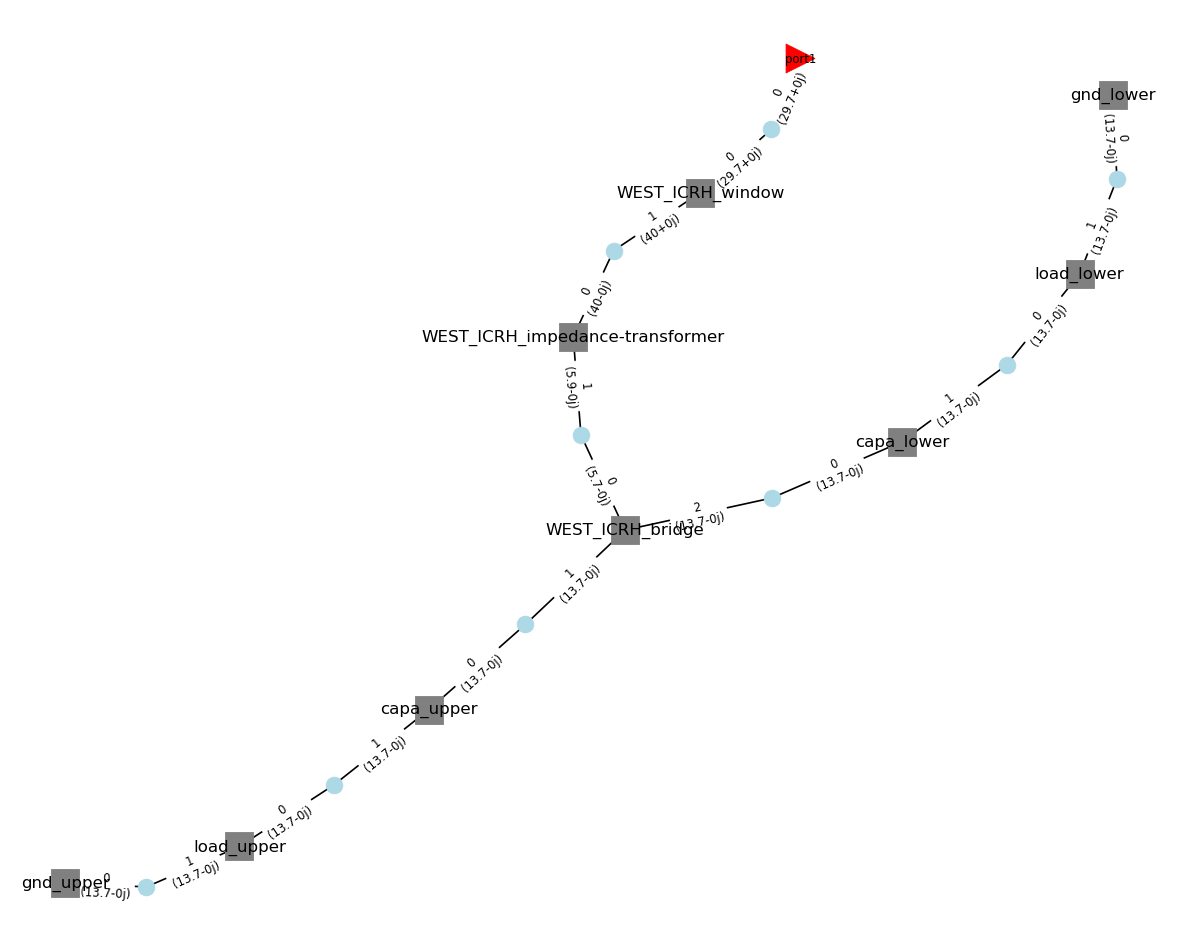

In [42]:
options = {
    'network_labels': True,
    'edge_labels': True, 
    'port_labels': True,
    'network_fontsize': 10,
    'inter_size': 100,
    'edge_fontsize': 7
}
half_antenna_circuit([50,50], Zload=1+30j).plot_graph(**options)

## Matching the Resonant Loop

Now that the network model has been built, let's find for which capacitance values the resonant loop is matched to port1 (that is, when $Z_{11}=Z_0$)

In [45]:
def optim_fun_RL(C, f_match=55e6, z_load=1+30j, z_match=30-0j):
    """
    Return the match condition C=[Cupper,Clower]
    """
    ntw = half_antenna_circuit(C, Zload=z_load).network
    
    index_f_match = np.argmin(np.abs(ntw.f - f_match))

    Z11_re = ntw.z_re[index_f_match,0,0].squeeze()
    Z11_im = ntw.z_im[index_f_match,0,0].squeeze()
    r = np.array([  # residuals for both real and imaginary parts
        (Z11_re - np.real(z_match)), 
        (Z11_im - np.imag(z_match))
    ])
    return r

In [46]:
%%prun
f_match = 55e6
z_load = 1 + 30j
z_match = 30 - 0j

# try finding a solution until it's a physical one.
success = False
while success == False:
    # generate a random C sets, centered on 70 +/- 40
    C0 = 70 + (-1 + 2*scipy.random.rand(2))*40
    # find the best solution
    sol = scipy.optimize.root(optim_fun_RL, C0,
                              args=(f_match, z_load, z_match))
    # test if the solution found is the capacitor range
    success = sol.success
    for idm,Cm in enumerate(sol.x):
        if (Cm < 12) or (Cm > 200):
            success = False
            print('Bad solution found (out of range capacitor) ! Re-doing...')
                    
    print(success, sol.x)

True [55.93249184 48.46211994]
 

Let's compare antenna's response versus frequency, with both circuit building approaches:

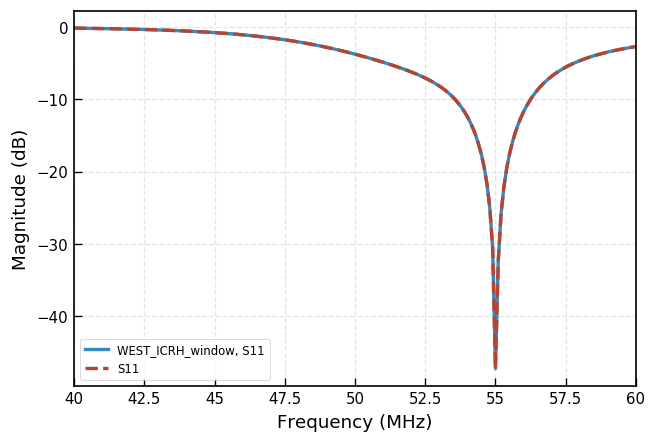

In [48]:
half_antenna_network(sol.x).plot_s_db(m=0, n=0, lw=2)
half_antenna_circuit(sol.x).network.plot_s_db(m=0, n=0, ls='--', lw=2)

## Capacitor Current and Voltages

## Full-antenna: Resonant Double Loop

# References

In [49]:
from IPython.core.display import HTML

def _set_css_style(css_file_path):
   """
   Read the custom CSS file and load it into Jupyter.
   Pass the file path to the CSS file.
   """

   styles = open(css_file_path, "r").read()
   s = '<style>%s</style>' % styles     
   return HTML(s)

_set_css_style('custom.css')